In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 50 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619416 sha256=3beb48371b19088132b4a6896843efa22c24227e6de2e15a39095ae41551d441
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader #Matrix Factorization-based algorithms SVDpp, SVD, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split

In [1]:
import math
from collections import defaultdict
import csv
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
file_path_train = '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/1m_training_data.csv'
file_path_test = '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/1m_testing_data.csv'
traindf = pd.read_csv(file_path_train)
testdf = pd.read_csv(file_path_test)

def convert_traintest_dataframe_forsurprise(training_dataframe, testing_dataframe):
    reader = Reader(rating_scale=(0, 5))
    trainset = Dataset.load_from_df(training_dataframe[['userId', 'movieId', 'rating']], reader)
    testset = Dataset.load_from_df(testing_dataframe[['userId', 'movieId', 'rating']], reader)
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)
    return trainset, testset

trainset, testset = convert_traintest_dataframe_forsurprise(traindf, testdf)

In [ ]:
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    org_ratings = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        org_ratings[uid].append((iid, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n, org_ratings

In [ ]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    precision = (sum(prec for prec in precisions.values()) / len(precisions))
    recall = (sum(rec for rec in recalls.values()) / len(recalls))

    return precision, recall

In [ ]:
def recommendation(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  start_fit = time.time()
  algo.fit(trainset)
  end_fit = time.time()
  fit_time = end_fit - start_fit

  # Predictions on testing set
  start_test = time.time()
  test_predictions = algo.test(testset)
  end_test = time.time()
  test_time = end_test - start_test

  test_rmse = accuracy.rmse(test_predictions)
  test_mae = accuracy.mae(test_predictions)

  top_n, org_ratings = get_top_n(test_predictions, 5)

  precision, recall = precision_recall_at_k(test_predictions)

  f_measure = (2*precision*recall)/(precision+recall)

  return (test_rmse, test_mae, fit_time, test_time, precision, recall, f_measure,ndcg_score,test_predictions)

In [ ]:
# basic collaborative filtering algorithm taking into account a baseline rating.
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

test_rmse, test_mae, test_predictions, fit_time, test_time, precision, recall, f_measure,ndcg_score = recommendation(algo,trainset,testset)
print(test_rmse)
print(test_mae)
print(fit_time)
print(test_time)
print(precision)
print(recall)
print(f_measure)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8575
MAE:  0.6725
0.8574772794258582
0.672453901355491
60.28068661689758
0.8484105960265129
0.4089603689503831
0.5518917169823347
0.9711154077563481


In [ ]:
algo = CoClustering(2,5,50)

test_rmse, test_mae, test_predictions, fit_time, test_time, precision, recall, f_measure, ndcg_score = recommendation(algo,trainset,testset)
print(test_rmse)
print(test_mae)
print(fit_time)
print(test_time)
print(precision)
print(recall)
print(f_measure)

RMSE: 0.9216
MAE:  0.7226
0.9216024520354248
0.7225932210966534
1.5430331230163574
0.8259961368653671
0.390323969635095
0.5301336207820402
0.9658297958026015


In [ ]:
surprise_df = pd.DataFrame(columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])

In [ ]:
# Iterate over all algorithms
for algorithm in [KNNBasic(), SVD(), SVDpp(), SlopeOne(), NMF(), KNNBaseline(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    results = recommendation(algorithm,trainset,testset) 
    
    name =str(algorithm).split(' ')[0].split('.')[-1]
    print("Algorithm:", name)
    df = pd.DataFrame([[name, results[0], results[1], results[2], results[3], results[4], results[5], results[6] ]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
    surprise_df = pd.concat([df, surprise_df], ignore_index=True)
surprise_df.sort_values(by='test_rmse', ascending=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9237
MAE:  0.7282
Algorithm: KNNBasic
RMSE: 0.8748
MAE:  0.6868
Algorithm: SVD
RMSE: 0.8649
MAE:  0.6777
Algorithm: SVDpp
RMSE: 0.9070
MAE:  0.7152
Algorithm: SlopeOne
RMSE: 0.9168
MAE:  0.7254
Algorithm: NMF
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8958
MAE:  0.7073
Algorithm: KNNBaseline
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9305
MAE:  0.7402
Algorithm: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9322
MAE:  0.7388
Algorithm: KNNWithZScore
Estimating biases using als...
RMSE: 0.9094
MAE:  0.7205
Algorithm: BaselineOnly
RMSE: 0.9177
MAE:  0.7194
Algorithm: CoClustering


,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure
2,KNNWithZScore,0.932221,0.738824,28.301350,140.961948,0.824983,0.372838,0.513574
3,KNNWithMeans,0.930516,0.740171,27.681766,139.237923,0.827635,0.369356,0.510768
9,KNNBasic,0.923711,0.728171,27.631806,135.125774,0.809100,0.413871,0.547623
0,CoClustering,0.917723,0.719429,13.169612,1.423964,0.825657,0.391008,0.530694
5,NMF,0.916834,0.725389,46.132791,1.553394,0.809581,0.379067,0.516361
1,BaselineOnly,0.909375,0.720478,2.617666,1.264593,0.811148,0.399975,0.535765
6,SlopeOne,0.907025,0.715197,12.541717,46.280245,0.817301,0.390491,0.528483
4,KNNBaseline,0.895820,0.707324,30.484252,145.684090,0.814277,0.402064,0.538322
8,SVD,0.874834,0.686799,42.721618,1.828414,0.833902,0.398786,0.539550
7,SVDpp,0.864873,0.677656,3126.597143,63.803133,0.842061,0.403431,0.545509


In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

results = recommendation(algo,trainset,testset)
df = pd.DataFrame([['KNNBaseline (pearson_baseline)', results[0], results[1], results[2], results[3], results[4], results[5], results[6] ]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
surprise_df = pd.concat([df, surprise_df], ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8575
MAE:  0.6725


In [ ]:
bsl_options = {'name': 'sgd',
               'learning_rate': .00005,  # compute  similarities between items
               }
algo = BaselineOnly(bsl_options=bsl_options)

results = recommendation(algo,trainset,testset)
df = pd.DataFrame([['sgd', results[0], results[1], results[2], results[3], results[4], results[5], results[6]]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
surprise_df = pd.concat([df, surprise_df], ignore_index=True)

Estimating biases using als...
RMSE: 0.9094
MAE:  0.7205


In [ ]:
surprise_df.sort_values(by='test_rmse')

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure
1,KNNBaseline (pearson_baseline),0.857477,0.672454,21.782633,60.072469,0.848411,0.408960,0.551892
9,SVDpp,0.864873,0.677656,3126.597143,63.803133,0.842061,0.403431,0.545509
10,SVD,0.874834,0.686799,42.721618,1.828414,0.833902,0.398786,0.539550
6,KNNBaseline,0.895820,0.707324,30.484252,145.684090,0.814277,0.402064,0.538322
8,SlopeOne,0.907025,0.715197,12.541717,46.280245,0.817301,0.390491,0.528483
0,sgd,0.909375,0.720478,2.584045,1.463554,0.811148,0.399975,0.535765
3,BaselineOnly,0.909375,0.720478,2.617666,1.264593,0.811148,0.399975,0.535765
7,NMF,0.916834,0.725389,46.132791,1.553394,0.809581,0.379067,0.516361
2,CoClustering,0.917723,0.719429,13.169612,1.423964,0.825657,0.391008,0.530694
11,KNNBasic,0.923711,0.728171,27.631806,135.125774,0.809100,0.413871,0.547623


In [ ]:
surprise_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/1m_Surprise_results.csv')

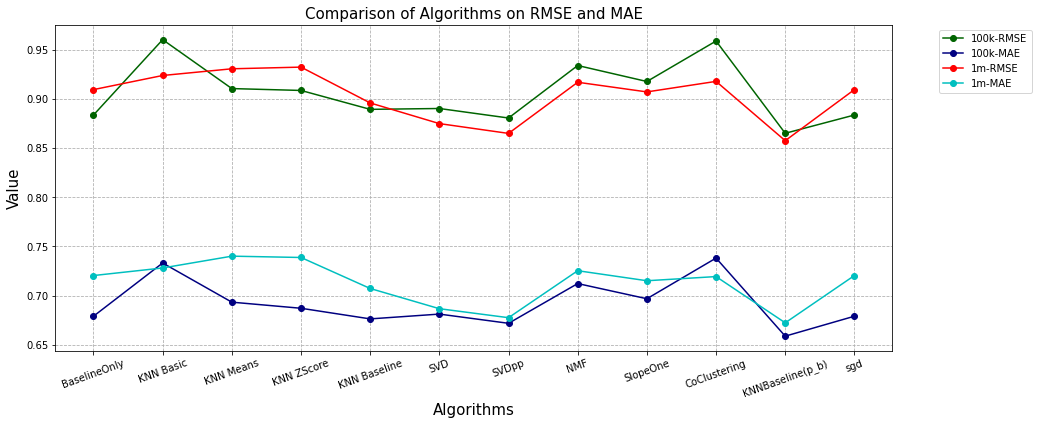

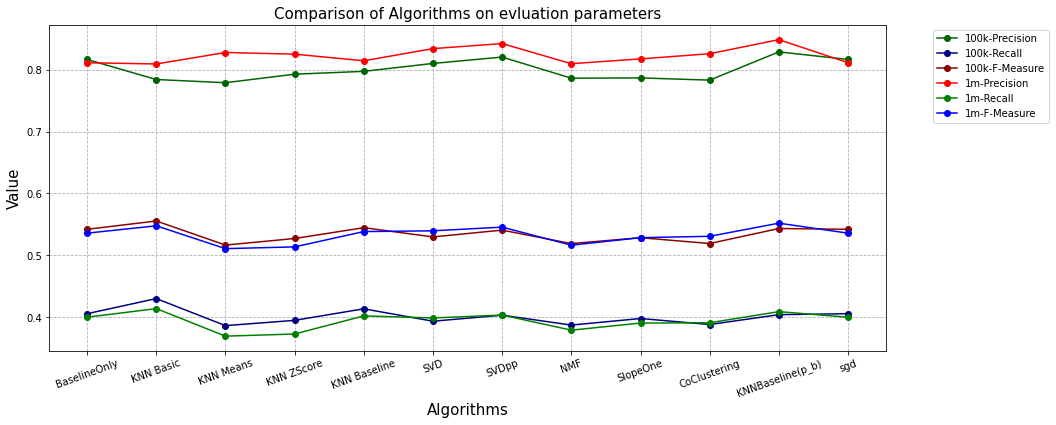

In [ ]:
x_algo = ['BaselineOnly','KNN Basic', 'KNN Means', 'KNN ZScore','KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering','KNNBaseline(p_b)','sgd']

rmse_100k = [0.883553, 0.960121,0.910415, 0.908513, 0.889314, 0.890175 ,0.880511, 0.933850, 0.917607,0.958728, 0.86500,0.883553]
mae_100k = [0.679160, 0.733222, 0.693436,0.687232, 0.676437,0.681319, 0.671955, 0.712330,0.696909,0.738220, 0.658901,0.679160]
rmse_1m = [0.909375, 0.923711,0.930516 , 0.932221,0.895820 ,0.874834 ,0.864873 ,0.916834 ,0.907025 ,0.917723 ,0.857477 , 0.909375]
mae_1m = [0.720478,0.728171 ,0.740171, 0.738824,0.707324	 ,0.686799 , 0.677656,0.725389 ,0.715197 ,0.719429, 0.672454,0.720478]

precision_100k = [0.816393,0.783989,0.778852 ,0.792596 , 0.797186,0.810000 ,0.820246 ,0.786148 , 0.786585 , 0.783005, 0.828634,0.816393]
recall_100k = [0.405654,0.430059 ,0.386358 ,0.394887 ,0.413553 ,0.393502 ,0.403249 ,0.387261 ,0.397853, 0.388160, 0.404076,0.405654]
f_measure_100k = [0.541997,0.555434 ,0.516501 ,0.527142 ,0.544591 , 0.529682, 0.540686, 0.518906, 0.528428,0.519023 , 0.543244,0.541997]
precision_1m = [0.811148,0.809100 ,0.827635 ,0.824983 ,0.814277 ,0.833902 ,0.842061  ,0.809581	 ,0.817301 , 0.825657,0.848411 ,0.811148]
recall_1m = [0.399975,0.413871 ,0.369356 ,0.372838 ,0.402064 ,0.398786 ,0.403431 ,0.379067,0.390491,0.391008 , 0.408960,0.399975]
f_measure_1m =  [0.535765,0.547623 ,0.510768 ,0.513574 ,0.538322 ,0.539550 ,0.545509 ,0.516361 ,0.528483 ,0.530694 ,0.551892 ,0.535765]


plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_100k, label='100k-RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae_100k, label='100k-MAE', color='navy', marker='o')
plt.plot(x_algo, rmse_1m, label='1m-RMSE', color='r', marker='o')
plt.plot(x_algo, mae_1m, label='1m-MAE', color='c', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(ls='dashed')
plt.show()

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on evluation parameters', loc='center', fontsize=15)
plt.plot(x_algo, precision_100k, label='100k-Precision', color='darkgreen', marker='o')
plt.plot(x_algo, recall_100k, label='100k-Recall', color='navy', marker='o')
plt.plot(x_algo, f_measure_100k, label='100k-F-Measure', color='darkred', marker='o')
plt.plot(x_algo, precision_1m, label='1m-Precision', color='r', marker='o')
plt.plot(x_algo, recall_1m, label='1m-Recall', color='g', marker='o')
plt.plot(x_algo, f_measure_1m, label='1m-F-Measure', color='b', marker='o')
# plt.plot(x_algo, ndcg, label='NDCG', color='purple', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(ls='dashed')
plt.show()

In [ ]:
def ratingprediction(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  algo.fit(trainset)

  # Predictions on testing set
  test_predictions = algo.test(testset)
  return test_predictions

In [ ]:
algo = KNNBasic()
test_knn_basic_pred = ratingprediction(algo, trainset, testset)

algo = SVD()
test_svd_pred = ratingprediction(algo, trainset, testset)

algo = SVDpp()
test_svdpp_pred = ratingprediction(algo, trainset, testset)

algo = SlopeOne()
test_s1_pred = ratingprediction(algo, trainset, testset)

algo = NMF()
test_nmf_pred = ratingprediction(algo, trainset, testset)

algo = KNNBaseline()
test_knn_baseline_pred = ratingprediction(algo, trainset, testset)

algo = KNNWithMeans()
test_knn_means_pred = ratingprediction(algo, trainset, testset)

algo = KNNWithZScore()
test_knn_zscore_pred = ratingprediction(algo, trainset, testset)

algo = BaselineOnly()
test_baseline_pred = ratingprediction(algo, trainset, testset)

algo = CoClustering()
test_co_pred = ratingprediction(algo, trainset, testset)

algo = KNNBaseline(sim_options={'name': 'pearson_baseline','user_based': False})
test_knn_pb_pred = ratingprediction(algo, trainset, testset)

algo = BaselineOnly(bsl_options={'name': 'sgd','learning_rate': .00005})
test_sgd_pred = ratingprediction(algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
test_pred_df = pd.DataFrame(columns= ['uid', 'iid', 'og_rating', 'knn_basic_rating', 'svd_rating', 'svdpp_rating', 's1_rating', 'nmf_rating','knn_baseline_rating',
                                      'knn_means_rating', 'zscore_rating', 'baseline_rating', 'co_rating','knn_pb_rating', 'sgd'])

In [ ]:
num_test = len(test_knn_means_pred)
print(num_test)

200042


In [ ]:
for i in range(num_test): 
  knn_basic = test_knn_basic_pred[i]
  svd = test_svd_pred[i]
  svdpp = test_svdpp_pred[i]
  s1 = test_s1_pred[i]
  nmf = test_nmf_pred[i]
  knn_baseline = test_knn_baseline_pred[i]
  knn_means = test_knn_means_pred[i]
  zscore = test_knn_zscore_pred[i]
  baseline = test_baseline_pred[i]
  co = test_co_pred[i]
  knn_pb = test_knn_pb_pred[i]
  sgd = test_sgd_pred[i]
  df = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, knn_basic.est, svd.est,
                      svdpp.est, s1.est, nmf.est,knn_baseline.est, knn_means.est, zscore.est,
                      baseline.est,co.est, knn_pb.est, sgd.est]], columns= ['uid', 'iid', 'og_rating', 'knn_basic_rating', 'svd_rating', 'svdpp_rating', 's1_rating', 'nmf_rating','knn_baseline_rating',
                                      'knn_means_rating', 'zscore_rating', 'baseline_rating', 'co_rating','knn_pb_rating', 'sgd'])
  # print(df)
  test_pred_df = pd.concat([df, test_pred_df], ignore_index=True)

In [ ]:
test_pred_df.head()

,uid,iid,og_rating,knn_basic_rating,svd_rating,svdpp_rating,s1_rating,nmf_rating,knn_baseline_rating,knn_means_rating,zscore_rating,baseline_rating,co_rating,knn_pb_rating,sgd
0,6040,3819,5.0,4.061102,3.718045,4.061397,3.673379,3.578640,3.826759,3.849862,3.842927,3.730976,3.944027,3.691019,3.730976
1,6040,3671,4.0,4.024891,3.553189,3.666309,3.770172,3.904634,3.728494,3.786973,3.831559,3.747257,3.992639,3.752256,3.747257
2,6040,3449,3.0,2.954077,2.942742,2.220191,2.771399,2.291494,2.820398,3.141986,3.092372,2.913382,2.769101,2.579497,2.913382
3,6040,3134,5.0,4.551846,4.410702,4.998213,4.062953,4.178109,4.222452,4.118073,4.270793,4.031052,4.251980,4.438376,4.031052
4,6040,3111,5.0,3.479836,3.221598,3.143815,3.442113,3.295606,3.319301,3.406453,3.348229,3.464963,3.660446,3.317930,3.464963


In [ ]:
test_pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/1m_test_prediction.csv')

In [ ]:
pred_data = test_pred_df
# num of rows:
T = pred_data.shape[0]
print(T)

200042


In [ ]:
knn_pb_wt = 0.05
svd_wt = 0.5
svdpp_wt = 0.3
sgd_wt = 0.02
baseline_wt = 0.02

In [ ]:
sqr_sum = 0
abs_sum = 0

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = knn_pb_wt*row['knn_pb_rating'] + svd_wt*row['svd_rating'] + svdpp_wt*row['svdpp_rating'] + sgd_wt*row['sgd'] + baseline_wt*row['baseline_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
  #sqr_sum
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8289999999336689
MAE 0.6200000269943312


In [ ]:
sqr_sum = 0
abs_sum = 0
knn_pb_wt = 0.2
svdpp_wt = 0.3

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = knn_pb_wt*row['knn_pb_rating'] + svdpp_wt*row['svdpp_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8323099453524042
MAE 0.6254988722368303


In [ ]:
sqr_sum = 0
abs_sum = 0
svdpp_wt = 0.04
sgd_wt = 0.3

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = svdpp_wt*row['svdpp_rating'] + sgd_wt*row['sgd']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8365036613435456
MAE 0.6354967726777377


In [ ]:
sqr_sum = 0
abs_sum = 0
sgd_wt = 0.3
knn_wt = 0.07

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = sgd_wt*row['sgd'] + knn_wt*row['knn_pb_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8659317840052669
MAE 0.6459945681406905


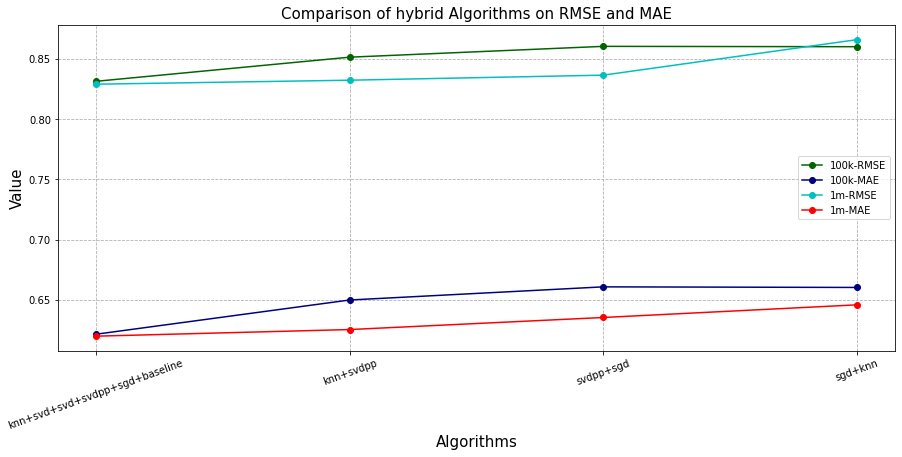

In [2]:
x_algo = ['knn+svd+svd+svdpp+sgd+baseline','knn+svdpp', 'svdpp+sgd', 'sgd+knn']

rmse_100k = [0.8314000035401449,0.8513999892470081, 0.8603794664329344, 0.8600912691530499]
mae_100k = [0.6216161579955481, 0.6500025783419279, 0.6609109480364935,0.6604151130503768]

rmse_1m = [0.8289999999336689,0.8323099453524042 ,0.8365036613435456 ,0.8659317840052669 ]
mae_1m = [0.6200000269943312,0.6254988722368303 ,0.6354967726777377 , 0.6459945681406905]
plt.figure(figsize=(15,6))
plt.title('Comparison of hybrid Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_100k, label='100k-RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae_100k, label='100k-MAE', color='navy', marker='o')
plt.plot(x_algo, rmse_1m, label='1m-RMSE', color='c', marker='o')
plt.plot(x_algo, mae_1m, label='1m-MAE', color='r', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()